##  TimeSerie Analysis - Data Science Specialization module
#### Part 2: Stock volatility analysis and forecast  
This notebook illustrates how TimeSerie analysis and modelization can be used to evaluate and forecast volatility trends in Stocks, index, bonds or any financial products.    

============================

## Let'start by importing all required packages

In [1]:
# data manipulation
import numpy as np
np.set_printoptions(linewidth=1000)
import pandas as pd
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from scipy.signal.filter_design import iirpeak
import pickle

# Financial market data handlers/loaders
import yfinance as yf
import mplfinance as mpf
import pandas_datareader.data as web
import pandas_datareader

# Statistics modelization
import statsmodels.tsa.api as tsa
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller, kpss 
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import probplot, moment
# from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess, arma_generate_sample
from arch import arch_model

# package pmdarima (conda install -c conda-forge pmdarima)
from pmdarima.arima import auto_arima

#time series clustering (conda install -c conda-forge tslearn )
from tslearn.generators import random_walks
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# visualization
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('whitegrid')

# time
from datetime import datetime
from datetime import timedelta

# Misc
from tqdm import tqdm  
import warnings
warnings.simplefilter("ignore")

## Let's define some helper functions 

In [2]:
# Helper functions
 
def plot_correlogram(x, lags=None, title=None):
    """ Plot Residuals, QQ-plot of residual and ACF/PACF using the provided Lag value.
        Also performs Ljung-Box and AD-Fuller tests to check stationnarity of the provided TimeSerie residuals.

        Notes: 
        - AD-Fuller test: The null hypothesis of the AD-Fuller test is that there is a unit root, with the alternative that there is no unit root. 
                          If the pvalue is BELOW a critical size (say 5%),  we reject the null i.e there is NO unit root and the TS is stationnary.
        - KPSS test: The null hypothesis for the test is that the data is stationary with the alternative that it is not.
                      If the pvalue is BELOW a critical size (say 5%),  we reject the null i.e the data is not stationnary.                          
        - Ljung-Box test: The null hypothesis of the Ljung-Box test is that residuals are independently distributed.
                          If the pvalue is BELOW a critical size (say 5%),  we reject the null i.e residuals are NOT independent.

    Args:
        x (pandas Series): Time Serie residuals (after trend and seasonal components removed, or 1st difference of TimeSerie)
        lags (int, optional): Desired lag for ACF/PACF analysis and display. Defaults to None.
        title (str, optional): TimeSerie description. Defaults to None.
    """
    warnings.simplefilter("ignore")
    
    # Some parameter definition
    p_crit = 0.05           # confidence level of 5% 
    roll_window = 12        # Number of data points for rolling window (12 as data is usually monthly)

    # First check & initialize the lag value
    if lags is None:
        lags = min(10, int(len(x)/5)) # set an arbitrary value if not defined

    # PerformAD-Full test 
    ADF = adfuller(x)  
    if ADF[1] < p_crit: 
        ADF_text = " => H0 rejected. Data is stationnary."
    else:
        ADF_text = " => Fail to reject H0. Cannot say data is stationnary."

    # Perform Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test 
    KPSS = kpss(x, nlags=lags)  
    if KPSS[1] < p_crit: 
        KPSS_text = " => H0 rejected. Data is not stationnary."
    else:
        KPSS_text = " => Fail to reject H0. Cannot say data is not stationnary."

    # Perform Ljung-Box test (max value for all lags)
    LB = np.max(acorr_ljungbox(x, lags=lags, return_df=False), axis=1)   
    if LB[1] < p_crit: 
        LB_text = " => H0 rejected. Residuals are not independent."
    else:
        LB_text = " => Fail to reject H0. Cannot say residuals are not independently distributed."

    # Define Multiplots figure
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))

    # Top-left plot: Residuals with ad-Fuller and Ljung-box tests 
    x.plot(ax=axes[0][0], title='TimeSerie'+f" (Lag: {lags} data points)")
    x.rolling(roll_window).mean().plot(ax=axes[0][0], c='k', lw=1)             # Rolling window average
    text = (f'AD-Fuller: stat:{ADF[0]:6.2f} p-val:{ADF[1]:6.4f}\n{ADF_text}\n'+
            f'KPSS: stat:{KPSS[0]:6.2f} p-val:{KPSS[1]:6.4f}\n{KPSS_text}')
    axes[0][0].text(x=.02, y=.75, s=text, transform=axes[0][0].transAxes, size = 10)
    axes[0][0].legend(["TimeSerie","Rolling window average"], loc=1)

    # Top-right plot: QQ-plot with the first 4 standardized moments (mean, var, skew, kurtosis)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    text = f'Mean: {mean:>9.2f}\nSD: {np.sqrt(var):>9.2f}\nSkew: {skew:9.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=text, transform=axes[0][1].transAxes)

    # Bottom-left plot:  Auto Correlation Function 
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    text = (f'Ljung-box: stat:{LB[0]:6.2f} p-val:{LB[1]:6.4f}\n{LB_text}')    
    axes[1][0].text(x=.02, y=.9, s=text, transform=axes[1][0].transAxes, size = 10)
    axes[1][0].set_xlabel('Lag')

    # Bottom-right plot: Partial Auto Correlation Function 
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1], method='ywm')
    axes[1][1].set_xlabel('Lag')

    # Adjust overall layout
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

def TimeSerie_OLS (Y, summary = True, plot = True, CI=True):
    """Runs a OLS on a Pandas time Series using the Series index as independent variable

    Args:
        Y (pandas Series): Time Serie data to regress
        summary (bool, optional): Switch for ploting the OLS model summary. Defaults to True.
        plot (bool, optional): Switch to plot the training data and linear model. Defaults to True.

    Returns:
        floats: a & b model parameters
    """
    
    y_train = Y.squeeze().dropna()
    X_train = y_train.index.to_julian_date()

    X_train = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train).fit()  
    a, b = model.params

    if CI:
        ConfInt = model.conf_int(alpha=0.05, cols=None)
    else:
        ConfInt = None

    if summary: 
        print(model.summary())  

    if plot:      
        plt.scatter(y_train.index, y_train, alpha=0.3)        
        y_predict = a + b * X_train[:,1]
        plt.plot( y_train.index,y_predict, linewidth=3, color="red")
        
    return a,b,ConfInt
    

## Let's now load some TimeSerie data 

The python library "pandas-datareader" bundles together many different APIs from various libraries to read TimeSeries data.   
(see a list of Internet sources available to Pandas-Reader there: https://pandas-datareader.readthedocs.io/en/latest/readers/index.html)   

Two TimeSeries data sources are of particular interest:    
1- Yahoo Finance: provides historical data on stocks, indexes, etc  (see available stocks there: https://finance.yahoo.com/lookup/)   
2- FRED (Federal Reserve Economic Data) for various US economic KPIs  (see official website: https://fred.stlouisfed.org/)

TimeSerie data shape: (5658, 6)

                 High        Low       Open      Close     Volume  Adj Close
Date                                                                        
2000-01-03  30.005434  28.736633  28.805216  28.976677  1094181.0  16.351425
2000-01-04  28.925238  26.953453  28.976677  27.690729  1671548.0  15.625769
2000-01-05  27.605000  26.679117  27.090620  27.433538  1033053.0  15.480636
2000-01-06  29.936850  27.022036  27.073475  29.405325  1678435.0  16.593306
                  High         Low        Open       Close    Volume   Adj Close
Date                                                                            
2021-12-30  140.000000  138.818176  139.109085  139.709091  496727.0  137.214294
2021-12-31  139.490906  138.781815  138.945450  139.381821  193363.0  136.892868


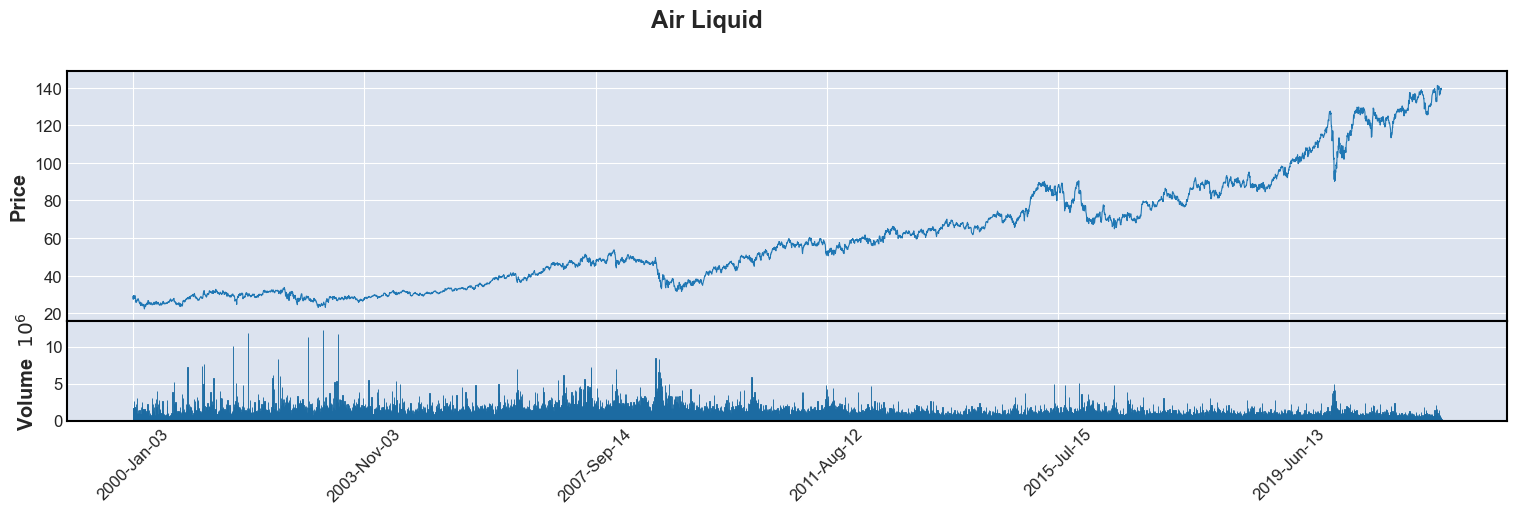

In [3]:
# From the course
# data = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv",header=0, index_col=0)

# Various TimeSerie datasets
#
# symbol, module, start, end, stock_name = "^FCHI", "yahoo", 1975, 2022,"CAC40" 
# symbol, module, start, end, stock_name = "^FTSE", "yahoo", 1975, 2022,"FSTE 100" # not workking
# symbol, module, start, end, stock_name = "^GSPC", "yahoo", 1975, 2022,"S&P 500" 
# symbol, module, start, end, stock_name = "^DJI", "yahoo", 1975, 2022,"Dow 30" 
# symbol, module, start, end, stock_name = "^IXIC", "yahoo", 1975, 2022,"Nasdaq" 
# symbol, module, start, end, stock_name = "^GDAXI", "yahoo", 1975, 2022,"DAX PERFORMANCE-INDEX" 
# symbol, module, start, end, stock_name = "IMOEX.ME", "yahoo", 1975, 2022,"MOEX Russia Index" 
# symbol, module, start, end, stock_name = "^N225", "yahoo", 1975, 2022,"Nikkei 225" 
# symbol, module, start, end, stock_name = "^MXX", "yahoo", 1975, 2022,"IPC MEXICO" 
# symbol, module, start, end, stock_name = "^KLSE", "yahoo", 1975, 2022,"FTSE Bursa Malaysia KLCI" 
# symbol, module, start, end, stock_name = "^HSI", "yahoo", 1975, 2022,"HANG SENG INDEX" 
# symbol, module, start, end, stock_name = "^BFX", "yahoo", 1975, 2022,"BEL 20" 
# symbol, module, start, end, stock_name = "^N100", "yahoo", 1975, 2022,"Euronext 100 Index" 

# symbol, module,  start, end,stock_name = "CRERF", "yahoo", 1975, 2022,"Carrefour" 
# symbol, module, start, end, stock_name =  "ZM", "yahoo", 1975, 2022,"Zoom"  
# symbol, module, start, end, stock_name = "TWTR", "yahoo", 1975, 2022,"Twiter stock" 
# symbol, module, start, end, stock_name = "TSLA", "yahoo", 1975, 2022,"Tesla stock"
# symbol, module, start, end, stock_name = "UBER", "yahoo", 1975, 2022,"UBER stock"
# symbol, module, start, end, stock_name = "DIS", "yahoo", 2015, 2022,"Disney"
symbol, module, start, end, stock_name = "AI.PA", "yahoo", 1975, 2022,"Air Liquid"
# symbol, module, start, end, stock_name = "", "yahoo", 1975, 2022,"Cap Gemini"
# symbol, module, start, end, stock_name = "GLE.PA", "yahoo", 1975, 2022,"Societe General"
# symbol, module, start, end, stock_name = "UBS", "yahoo", 1975, 2022,"UBS"
# symbol, module, start, end, stock_name = "DHY", "yahoo", 1975, 2022,"Credit Suisse High Yield Bond Fund, Inc."
# symbol, module, start, end, stock_name = "NOVN.SW", "yahoo", 1975, 2022,"Novartis AG "




# We load the data as a Pandas DataFrame or Series (depending on data type or source)
data = web.DataReader(symbol, module , start=start, end=end).squeeze().dropna()
# print (data.info())
print(f"TimeSerie data shape: {data.shape}")
# print(f"TimeSerie data type: {type(data)}")

# Print some info
print()
print(data.head(4))
print(data.tail(2))

# Check if data is Historical (Dataframe) or Real-Time (Series), plot the TimeSerie, isolate "Closing price"
# Note: Historical data multipple Series with Date, Open Price, High Price, Low Price, Closing Price & Volume
if isinstance(data, pd.DataFrame):
    mpf.plot(data,type='line',volume=True, figsize=(20,5), title=stock_name)
    data = data.Close.squeeze().dropna()
else:
    data.plot(figsize=(20, 5), title=stock_name)
    plt.show()

# Save data for later recovery
data.to_csv(stock_name, header=False, index=False)

### TimeSerie transformation using differentiation
TimeSerie differentiation can be used to reach stationarity.  
Similarly Stock return is the percentage change between 2 consecutive days. 

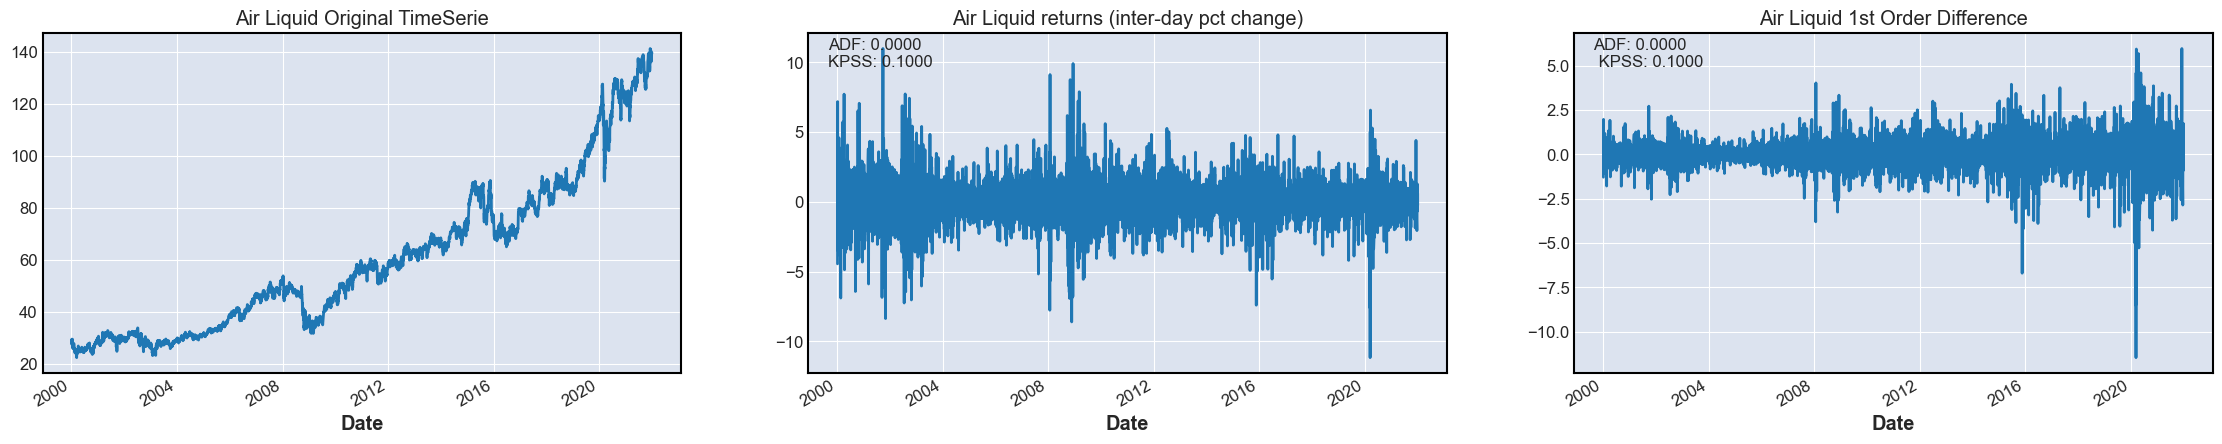

In [4]:
# Calculating returns and 1st difference of the stock values
returns = 100*data.pct_change().dropna()
data_diff = data.diff().dropna()

# Plot TimeSerie differentiation
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(28, 5))
data.plot(ax=axes[0], title=stock_name+" Original TimeSerie")

returns.plot(ax=axes[1], title=stock_name+" returns (inter-day pct change)")
axes[1].text(x=.03, y=.9, s=f'ADF: {adfuller(returns)[1]:.4f}\nKPSS: {kpss(returns, nlags=5)[1]:.4f}', transform=axes[1].transAxes)

data_diff.plot(ax=axes[2], title=stock_name+" 1st Order Difference")
axes[2].text(x=.03, y=.9, s=f'ADF: {adfuller(data_diff)[1]:.4f}\n KPSS: {kpss(data_diff, nlags=10)[1]:.4f}', transform=axes[2].transAxes)

fig.align_ylabels(axes)
plt.show()


Comments:    
- ADF test: p-val < 5% => presence of unit root rejected
- KPSS test: p-val > 5% => fail to reject that TimeSerie is stationnary. 
- According to the tests, the inter-day percentage change (or the 1st difference) are stationnary within a 5% confidence level.
- The stock results fluctuations however are varying with time. We have heteroskedacity of the data.   
- This stock results data is a good candidate for a GARCH model as there are changes in volatility over time. 
- The GARCH model is useful to forecast not the value of the stock but its volatility.

Let's now plot the ACF and PACF of the Stock returns.

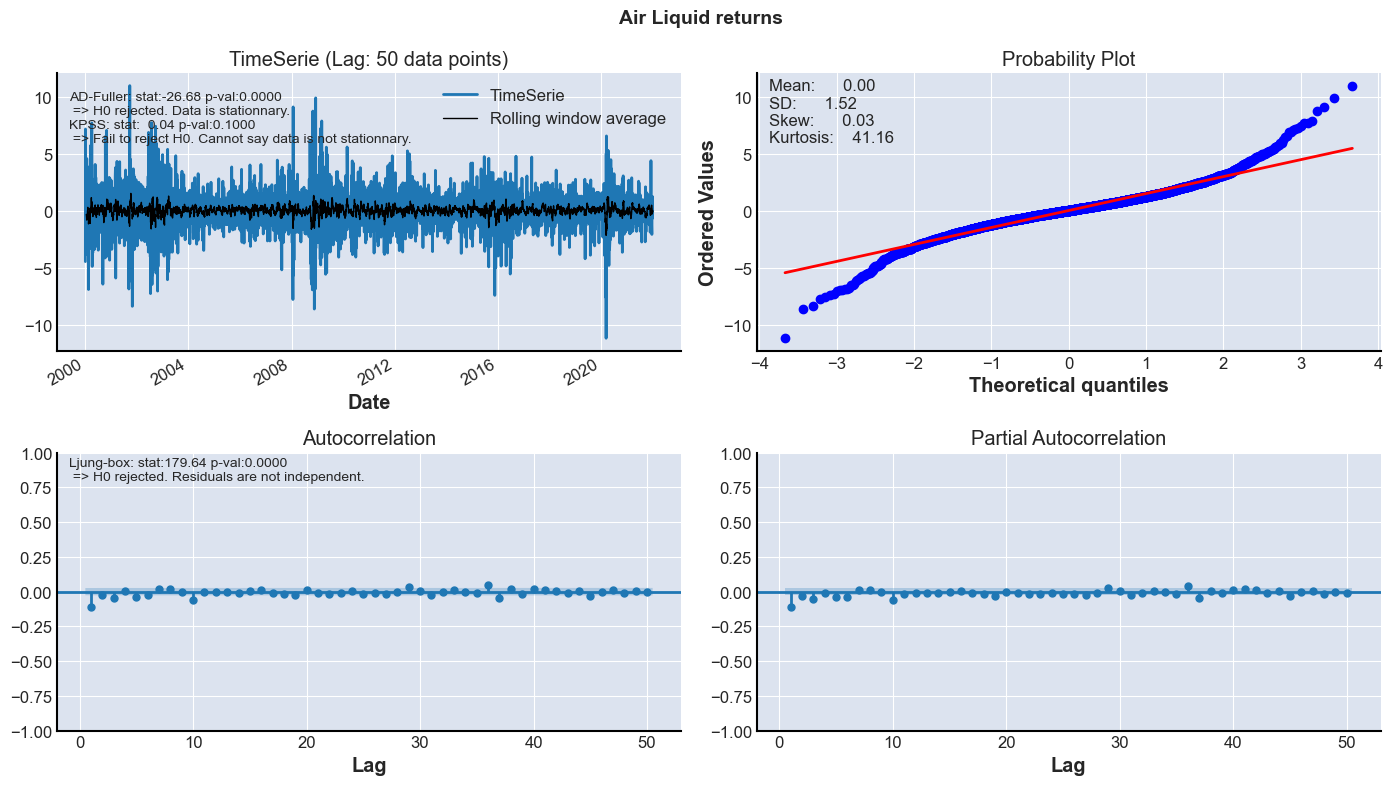

In [5]:
plot_correlogram(returns, lags=50, title=stock_name+" returns")

Comments:   
- The stock results values seem to follow an ARMA (1,1) process.  
- Having said that the ACF & PACF coefficients are very small which suggests the TimeSerie is not far off being white noise.  
- For the volatility however we'll have to look at the square of the stock results.

Let's now look at the ACF and PACF of the Stock volatility

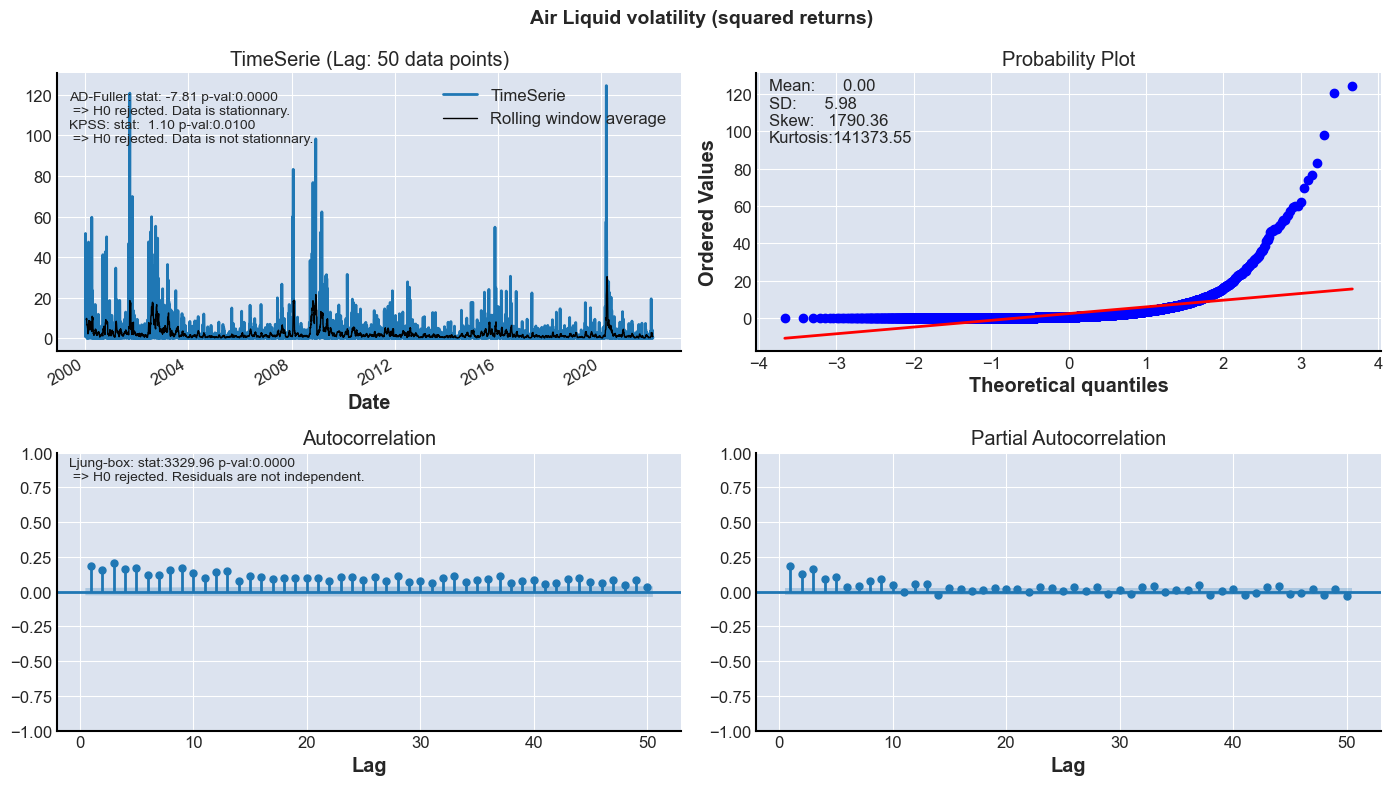

In [6]:
plot_correlogram(returns**2, lags=50, title=stock_name+" volatility (squared returns)")

Comments:   
- The PACF shows high order coefficients but the first 3 coefs are the largest so we could start with a GARCH (3,3) model. 
- Having said that the PACF coefficients tapper down fromthe 1st coefficient which suggest a GARCH(1,1) model might actually be enough to model volatility for this stock.

Fit a GARCH (3,3) model on the stock returns

In [7]:
# Split the data into training and test sets
TEST_SIZE = 5*12
train, test = returns.iloc[:-TEST_SIZE], returns.iloc[-TEST_SIZE:]

# Create and fit an GARCH model 
GARCH_model = arch_model(train, p=1, q=1, dist="studentst") 
GARCH_model_fit = GARCH_model.fit(disp='off', update_freq=5)

print (GARCH_model_fit.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:               -9542.61
Distribution:      Standardized Student's t   AIC:                           19095.2
Method:                  Maximum Likelihood   BIC:                           19128.4
                                              No. Observations:                 5597
Date:                      Wed, Jul 20 2022   Df Residuals:                     5592
Time:                              13:39:47   Df Model:                            5
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

Comments:  
- GARCH(3,3)   => LL=-9588, AIC=19195, BIC=19255 but ALL Coef have no confidence (<5%)   
- GARCH(9,9)   => LL=-9583, AIC=19208, BIC=19348 but ALL Coef have no confidence (<5%)  
- GARCH(2,2)   => LL=-9589, AIC=19192, BIC=19239 but ALL Coef have no confidence (<5%)  
- GARCH(1,1) => LL=-9590, AIC=19191, BIC=19223 AND ALL Coef have confidence (<5%)   

 From the above results it appears that a GARCH(1,1) is actually a better model than a GARCH(3,3).


### Let's now calculate a 1-day rolling prediction of volatility

In [8]:
# Initializing variables, starting rolling prediction after 10 data points
fcast_horizon = 1
rolling_predictions = []
test_size_tmp = train.shape[0]-10

# Rolling forecast 
for i in tqdm(range(0,test_size_tmp,fcast_horizon)):
    train_tmp = train[:-(test_size_tmp-i)]              # Include "fcast_horizon" days of data at each iteration iteration
    model = arch_model(train_tmp, p=1, q=1)             # Initialize GARCH model
    model_fit = model.fit(disp='off')                   # refit the GARCH model
    pred = model_fit.forecast(horizon=fcast_horizon)    # Make a X-day forecast
    rolling_predictions.extend(np.sqrt(pred.variance.values[-1,:].tolist())) # Append forecast to rolling_prediction

# Formatting the prediction as a Serie
new_index = train.index[10:].append(pd.date_range(start = train.index[-1]+ timedelta(days=1), periods = abs(len(train)-len(rolling_predictions)-10)))
rolling_predictions = pd.Series(rolling_predictions, index=new_index)

100%|██████████| 5587/5587 [03:30<00:00, 26.59it/s]


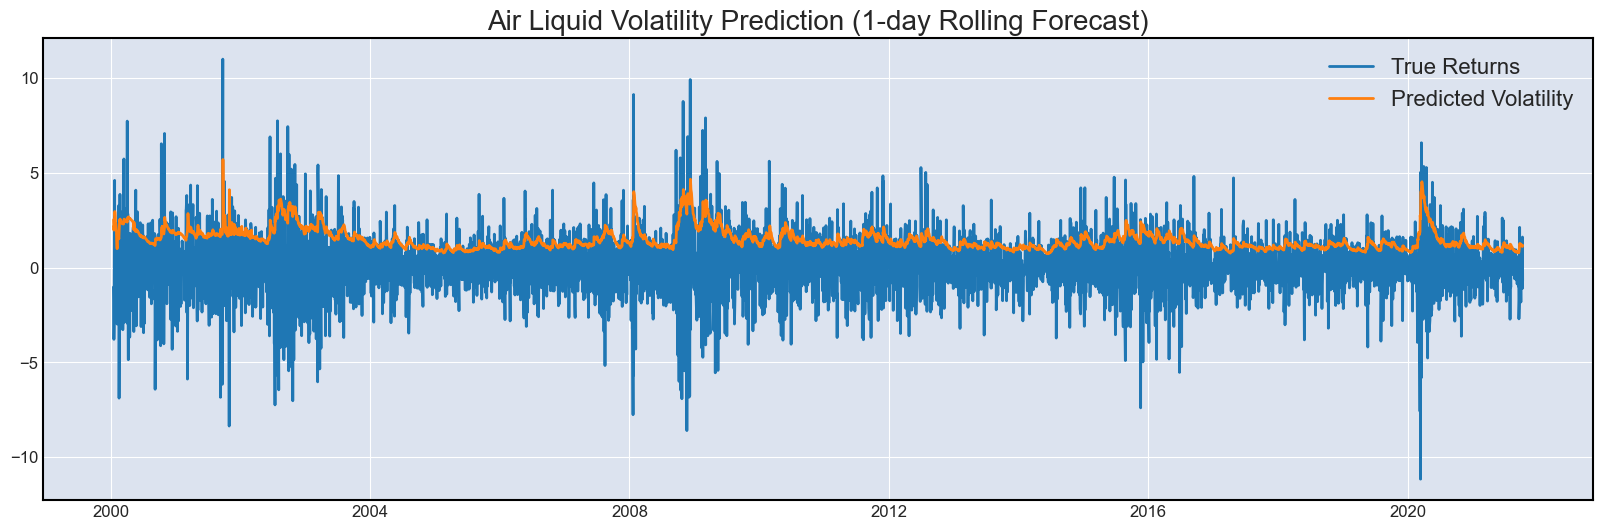

In [9]:
# Plotting the Results and Rolling predictions together
plt.figure(figsize=(20,6))
true, = plt.plot(train[-test_size_tmp:])
preds, = plt.plot(rolling_predictions)
plt.title(stock_name+f' Volatility Prediction ({fcast_horizon}-day Rolling Forecast)', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)


Comments:  
- We can see that volatility increases when the stock returns varies with large amplitude.   
- The GARCH model predicts fairly well volatility with a 1-day rolling forecast.   


### Let's check a 5-days rolling forecast

In [10]:
# Initializing variables, starting rolling prediction after 10 data points
fcast_horizon = 5
rolling_predictions = []
test_size_tmp = train.shape[0]-10

# Rolling forecast 
for i in tqdm(range(0,test_size_tmp,fcast_horizon)):
    train_tmp = train[:-(test_size_tmp-i)]              # Include "fcast_horizon" days of data at each iteration iteration
    model = arch_model(train_tmp, p=1, q=1)             # Initialize GARCH model
    model_fit = model.fit(disp='off')                   # refit the GARCH model
    pred = model_fit.forecast(horizon=fcast_horizon)    # Make a X-day forecast
    rolling_predictions.extend(np.sqrt(pred.variance.values[-1,:].tolist())) # Append forecast to rolling_prediction

# Formatting the prediction as a Serie
new_index = train.index[10:].append(pd.date_range(start = train.index[-1]+ timedelta(days=1), periods = abs(len(train)-len(rolling_predictions)-10)))
rolling_predictions = pd.Series(rolling_predictions, index=new_index)

100%|██████████| 1118/1118 [00:46<00:00, 24.23it/s]


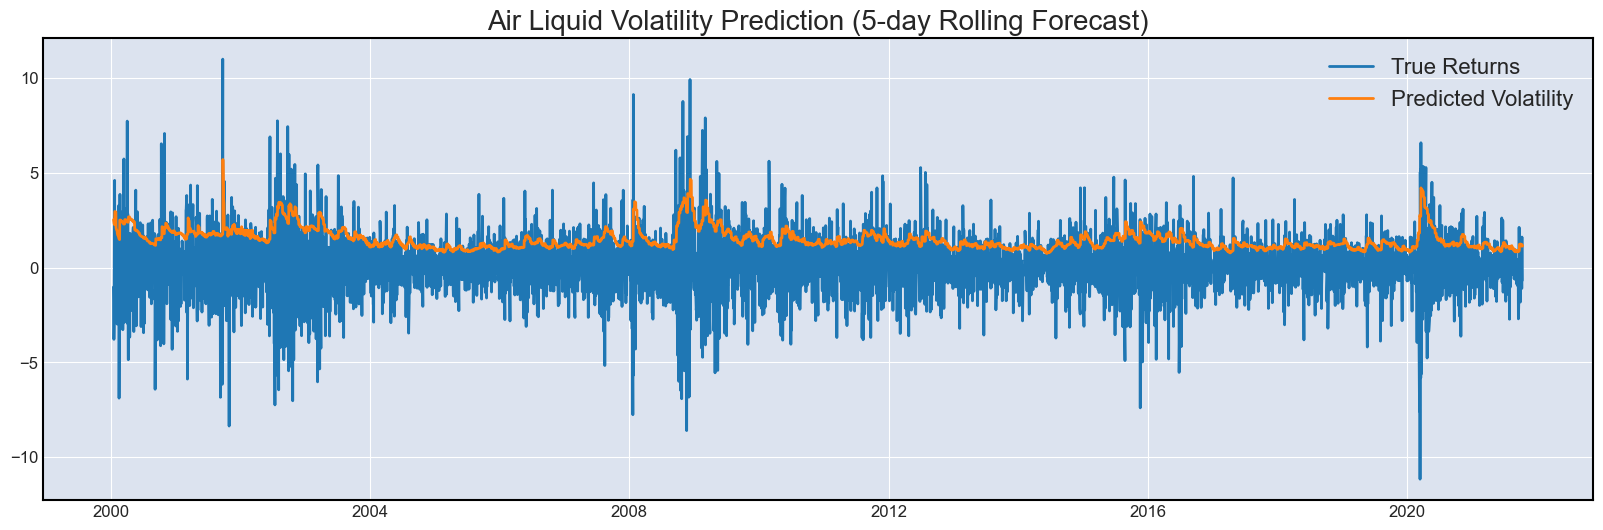

In [11]:
# Plotting the Results and Rolling predictions together
plt.figure(figsize=(20,6))
true, = plt.plot(train[-test_size_tmp:])
preds, = plt.plot(rolling_predictions)
plt.title(stock_name+f' Volatility Prediction ({fcast_horizon}-day Rolling Forecast)', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)


### Let's check a 10-days rolling forecast

In [12]:
# Initializing variables, starting rolling prediction after 10 data points
fcast_horizon = 10
rolling_predictions = []
test_size_tmp = train.shape[0]-10

# Rolling forecast 
for i in tqdm(range(0,test_size_tmp,fcast_horizon)):
    train_tmp = train[:-(test_size_tmp-i)]              # Include "fcast_horizon" days of data at each iteration iteration
    model = arch_model(train_tmp, p=1, q=1)             # Initialize GARCH model
    model_fit = model.fit(disp='off')                   # refit the GARCH model
    pred = model_fit.forecast(horizon=fcast_horizon)    # Make a X-day forecast
    rolling_predictions.extend(np.sqrt(pred.variance.values[-1,:].tolist())) # Append forecast to rolling_prediction

# Formatting the prediction as a Serie
new_index = train.index[10:].append(pd.date_range(start = train.index[-1]+ timedelta(days=1), periods = abs(len(train)-len(rolling_predictions)-10)))
rolling_predictions = pd.Series(rolling_predictions, index=new_index)

100%|██████████| 559/559 [00:21<00:00, 25.66it/s]


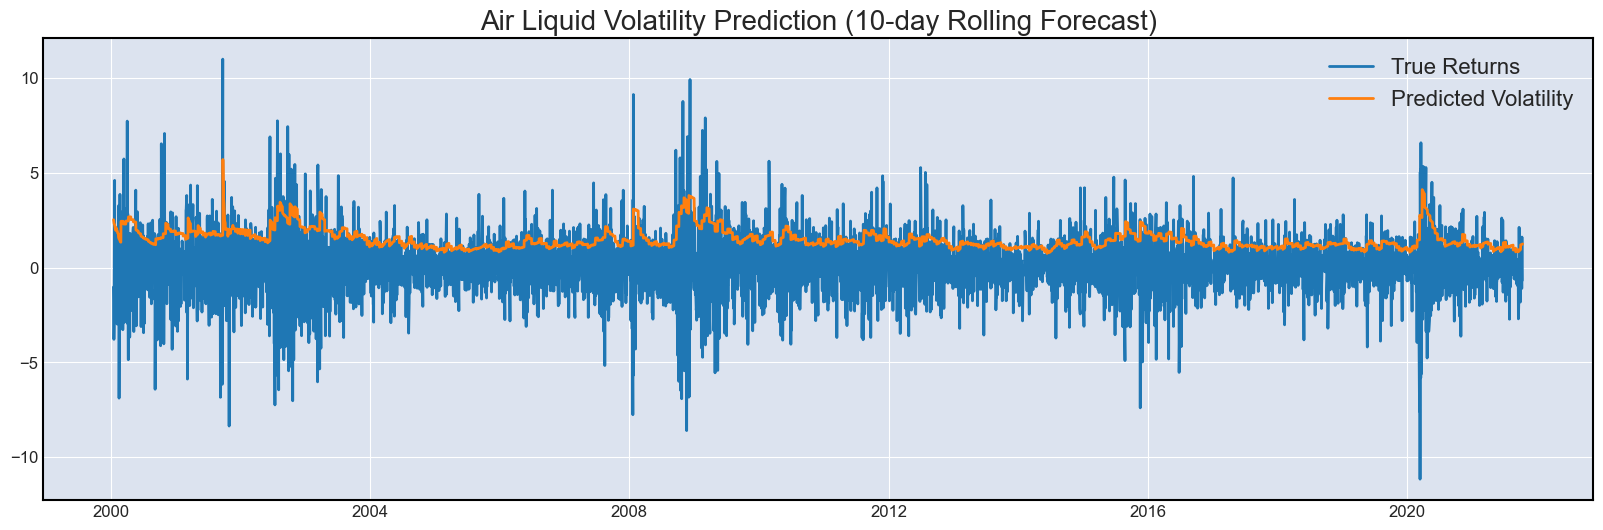

In [13]:
# Plotting the Results and Rolling predictions together
plt.figure(figsize=(20,6))
true, = plt.plot(train[-test_size_tmp:])
preds, = plt.plot(rolling_predictions)
plt.title(stock_name+f' Volatility Prediction ({fcast_horizon}-day Rolling Forecast)', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)


Comments:   
- Even the 10-days forecast provides a good estimate of volatility of the stock

### Let's now make a prediction over the test data

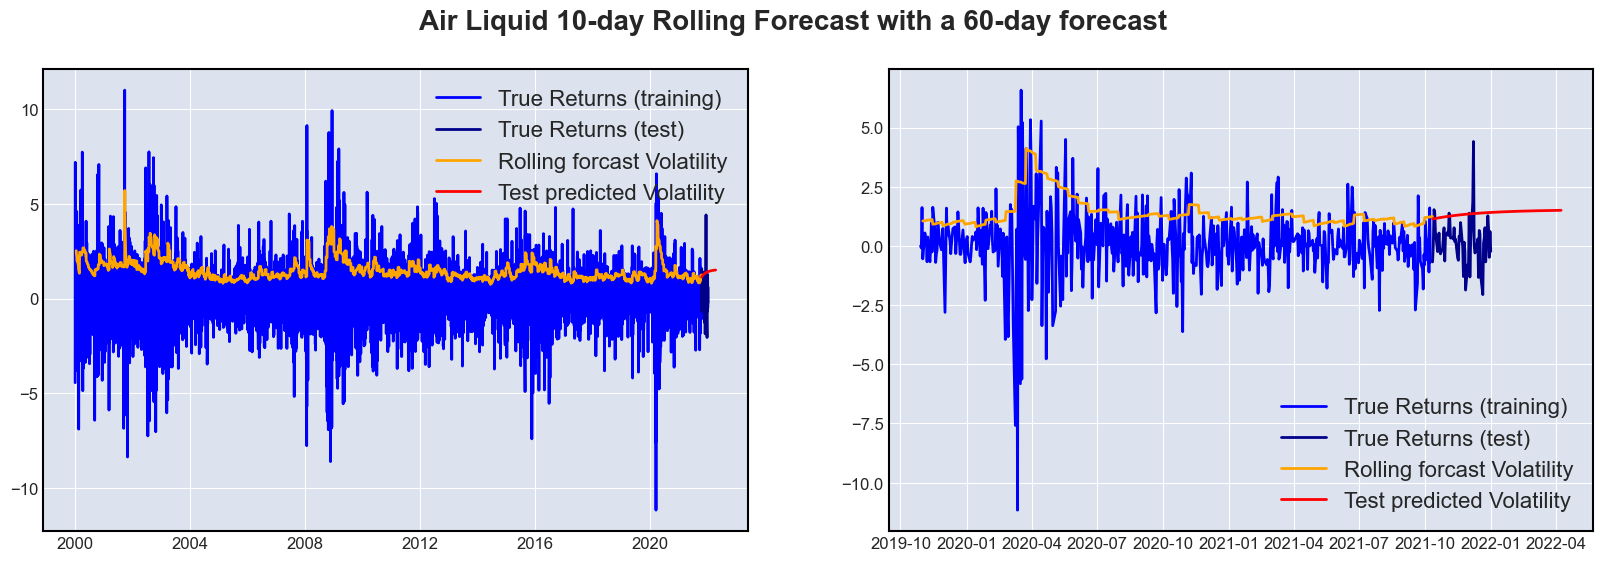

In [14]:
preds_length = 3*TEST_SIZE


test_preds = []
GARCH_model_fit_preds = GARCH_model_fit.forecast(horizon=preds_length) 
test_preds.extend(np.sqrt(GARCH_model_fit_preds.variance.values[-1,:].tolist()))
test_preds = pd.Series(test_preds, index=pd.date_range(start=test.index[0], periods=preds_length, freq="D"))

# Plotting the Results and Rolling predictions together
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,6))
plt.suptitle(stock_name+f' {fcast_horizon}-day Rolling Forecast with a {TEST_SIZE}-day forecast', fontsize=20)

ax1.plot(train, color='blue')
ax1.plot(test, color='darkblue')
ax1.plot(rolling_predictions[:len(train)], color='orange')
ax1.plot(test_preds, color='red')
ax1.legend(['True Returns (training)','True Returns (test)', 'Rolling forcast Volatility', 'Test predicted Volatility'], fontsize=16)
ax2.plot(train[-500:], color='blue')
ax2.plot(test, color='darkblue')
ax2.plot(rolling_predictions[-500:], color='orange')
ax2.plot(test_preds, color='red')
ax2.legend(['True Returns (training)','True Returns (test)', 'Rolling forcast Volatility', 'Test predicted Volatility'], fontsize=16)


Comments:  
- The volatility prediction over the test dataset is a trend which "levels off".   
- However the trend for the test dataset is that vloatility will slightly increase, which is the case when looking at the returns fluctuations over the test timeline.  
- The GARCH model is therefore successful in predicting the upcoming trend for the volatility but not the details of future volatility behaviours.  


### Let's now do a similar exercise throughout the entire Stock timeline and display volatility trends forecasted at different point in time, then compare with what happened in the "True" volatility (predicted with a rolling forecast)

In [15]:
plt.rcParams['figure.figsize'] = [20,6]

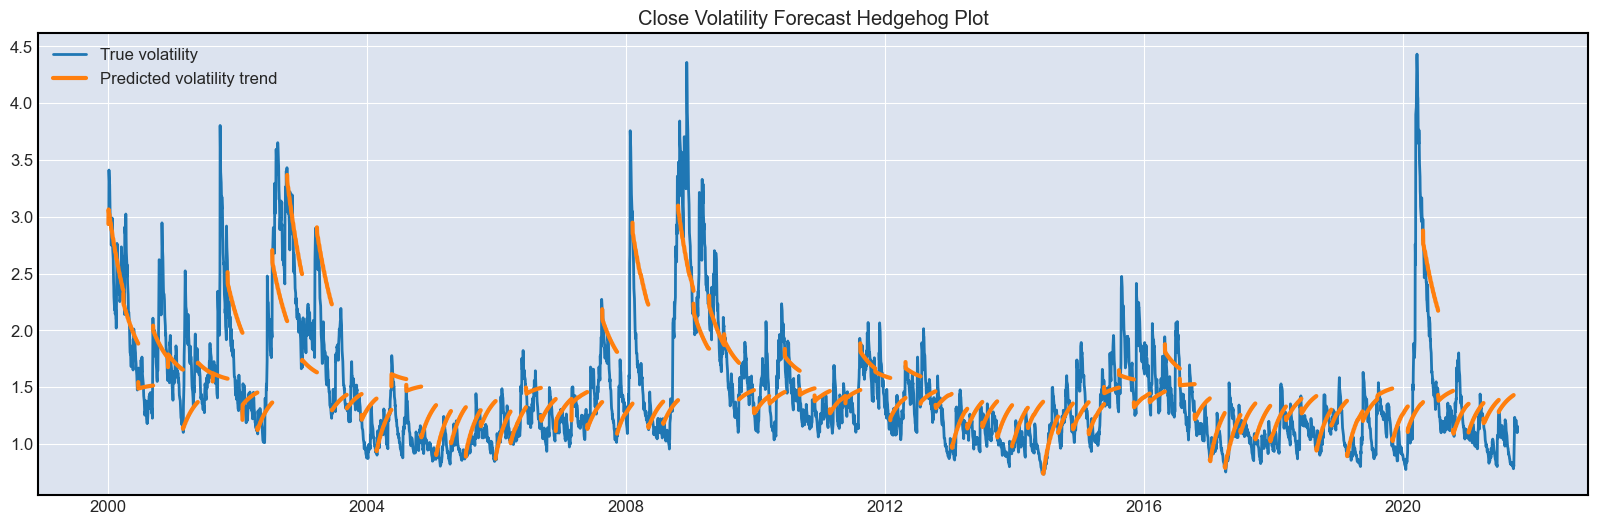

In [16]:
GARCH_model_fit.hedgehog_plot(plot_type='volatility', start="2000", horizon=TEST_SIZE, step=TEST_SIZE, method='analytic')
plt.legend(["True volatility", "Predicted volatility trend"])